## **Classification-based Rating Mode Prediction using Embedding Features (Model Selection)**


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

#### **Data Preparation**

In [2]:
rating_df = pd.read_csv('ratings.csv')
user_emb = pd.read_csv('User_Embeddings.csv')
item_emb = pd.read_csv('Course_Embeddings.csv')
course_df = pd.read_csv('course_processed.csv')

In [3]:
train_list = []
test_list = []

for user_id, user_data in rating_df.groupby('user'):
    if len(user_data) == 1:
        train_list.append(user_data)
    else:
        test_sample = user_data.sample(frac=0.2, random_state=42)
        train_sample = user_data.drop(test_sample.index)
        train_list.append(train_sample)
        test_list.append(test_sample)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

In [4]:
# Merge user embedding features (training df)
user_emb_train_merged = pd.merge(train_df, user_emb, how='left', left_on='user', right_on='User_ID').fillna(0)
# Merge course embedding features (training df)
merged_train_df = pd.merge(user_emb_train_merged, item_emb, how='left', left_on='item', right_on='Course_ID').fillna(0)

# Merge user embedding features (testing df)
user_emb_test_merged = pd.merge(test_df, user_emb, how='left', left_on='user', right_on='User_ID').fillna(0)
# Merge course embedding features (testing df)
merged_test_df = pd.merge(user_emb_test_merged, item_emb, how='left', left_on='item', right_on='Course_ID').fillna(0)

In [5]:
u_feautres = [f"User_Feature_{i}" for i in range(user_emb.shape[1] - 1)]
c_features = [f"Course_Feature_{i}" for i in range(item_emb.shape[1] - 1)]

user_train_embeddings = merged_train_df[u_feautres]
course_train_embeddings = merged_train_df[c_features]
ratings_train = merged_train_df['rating']

user_test_embeddings = merged_test_df[u_feautres]
course_test_embeddings = merged_test_df[c_features]
ratings_test = merged_test_df['rating']

x_train = user_train_embeddings + course_train_embeddings.values
x_train.columns = [f"Feature_{i}" for i in range(item_emb.shape[1] - 1)]
y_train = ratings_train

x_test = user_test_embeddings + course_test_embeddings.values
x_test.columns = [f"Feature_{i}" for i in range(item_emb.shape[1] - 1)]
y_test = ratings_test

In [6]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.values.ravel())
y_test = label_encoder.transform(y_test.values.ravel())

#### **Model Selection**

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import warnings
import pandas as pd
warnings.filterwarnings("ignore")

models_and_params = {
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__solver": ["liblinear"]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7],
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2]
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5],
            "model__criterion": ["gini", "entropy"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10, 20],
            "model__max_features": ["sqrt"]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 5]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 5]
        }
    }
}

results = []

for name, mp in models_and_params.items():
    print(f"\nRunning GridSearchCV for {name}...")

    scaling_model = ['LogisticRegression', 'KNN']

    if name in scaling_model:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', mp['model'])
        ])
    else:
        pipe = Pipeline([
            ('model', mp['model'])
        ])

    grid = GridSearchCV(estimator=pipe, param_grid=mp['params'], scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "AUC": auc,
        "F1 Score": f1
    })

results_df = pd.DataFrame(results)
print("\nFinal Model Comparison:")
results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)


Running GridSearchCV for LogisticRegression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Running GridSearchCV for KNN...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Running GridSearchCV for DecisionTree...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Running GridSearchCV for RandomForest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Running GridSearchCV for GradientBoosting...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Running GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Final Model Comparison:


,Model,Best Params,Accuracy,Precision,Recall,AUC,F1 Score
0,RandomForest,"{'model__max_depth': None, 'model__max_feature...",0.991657,0.989639,0.991657,0.615940,0.989670
1,LogisticRegression,"{'model__C': 0.1, 'model__solver': 'liblinear'}",0.991245,0.989159,0.991245,0.555629,0.988047
2,XGBoost,"{'model__learning_rate': 0.1, 'model__max_dept...",0.990582,0.988015,0.990582,0.610589,0.988793
3,GradientBoosting,"{'model__learning_rate': 0.1, 'model__max_dept...",0.989760,0.987297,0.989760,0.612578,0.988257
4,DecisionTree,"{'model__criterion': 'gini', 'model__max_depth...",0.987931,0.986312,0.987931,0.614059,0.987066
5,KNN,"{'model__n_neighbors': 3, 'model__p': 1, 'mode...",0.983885,0.986392,0.983885,0.655291,0.985077


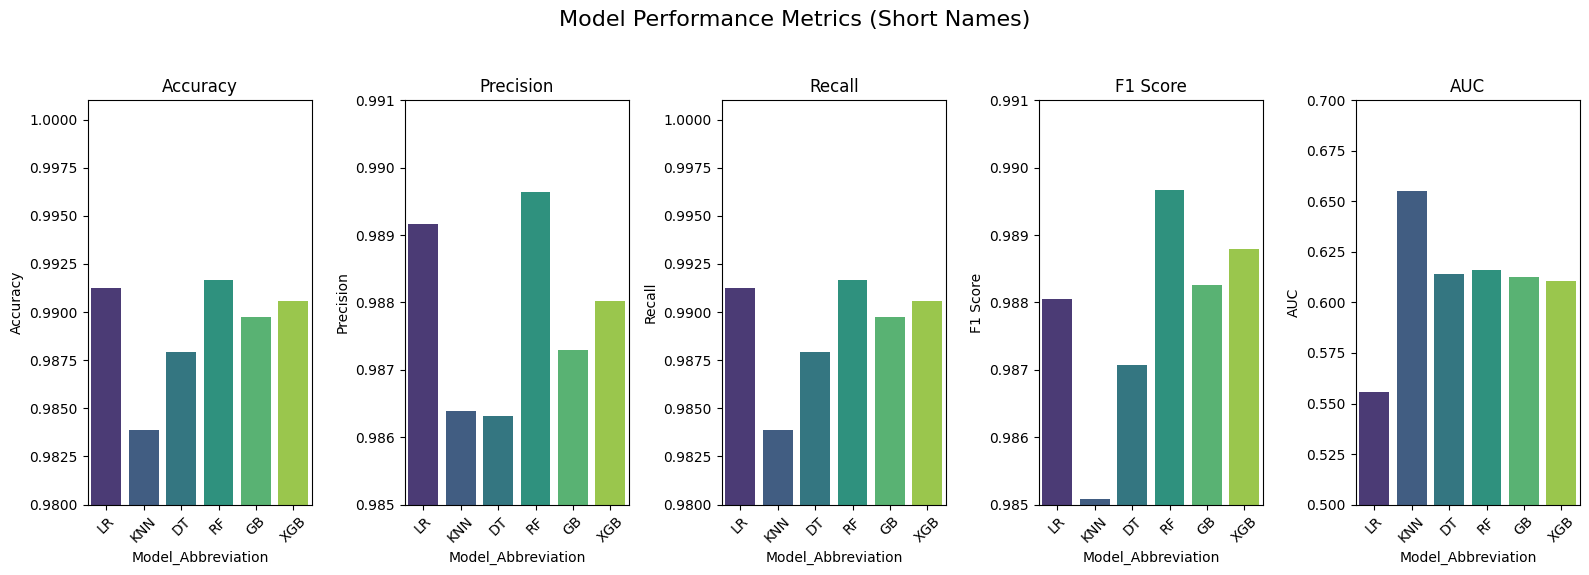

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

short_model_names = {
    "RandomForest": "RF",
    "LogisticRegression": "LR",
    "XGBoost": "XGB",
    "GradientBoosting": "GB",
    "DecisionTree": "DT",
    "KNN": "KNN"
}
results_df['Model_Abbreviation'] = results_df['Model'].map(short_model_names)

ylim_ranges = {
    'Accuracy': (0.98, 1.001),
    'Precision': (0.985, 0.991),
    'Recall': (0.98, 1.001),
    'F1 Score': (0.985, 0.991),
    'AUC': (0.5, 0.7)
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
plt.figure(figsize=(16, 6))

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 5, i)
    sns.barplot(data=results_df, x='Model_Abbreviation', y=metric, palette="viridis")
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylim(ylim_ranges[metric])  
    plt.tight_layout()

plt.suptitle("Model Performance Metrics (Short Names)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

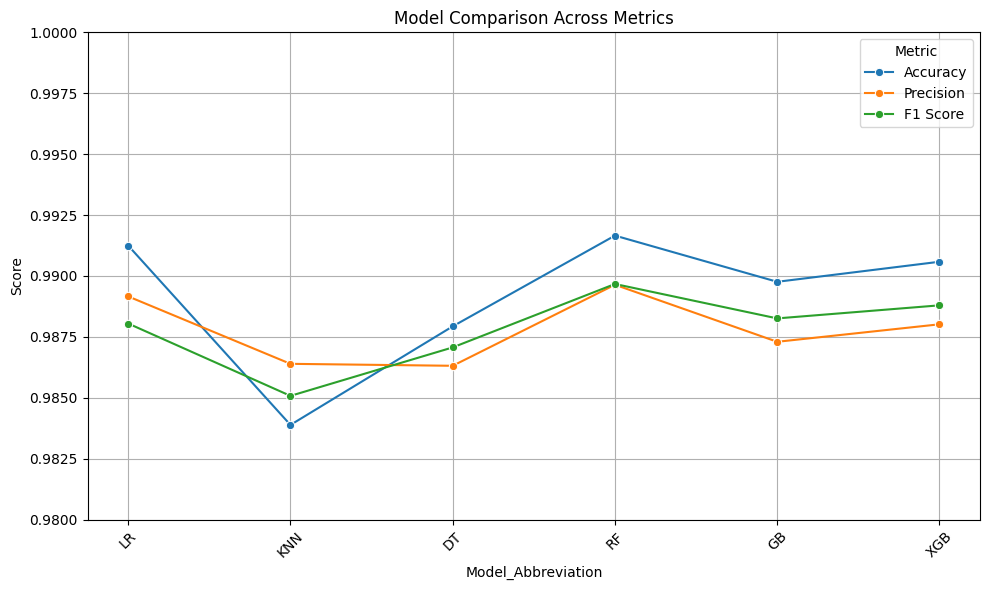

In [9]:
long_df = results_df.melt(id_vars="Model_Abbreviation", 
                         value_vars=["Accuracy", "Precision", "F1 Score"], 
                         var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.lineplot(data=long_df, x="Model_Abbreviation", y="Score", hue="Metric", marker="o", palette="tab10")
plt.title("Model Comparison Across Metrics")
plt.xticks(rotation=45)
plt.ylim(0.98, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Hyper Parameter Tuning**

In [10]:

pipe = Pipeline([
    ('model', RandomForestClassifier(random_state=42))
])

# Define hyperparameter grid
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", "log2"]
}

# GridSearchCV
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
grid.fit(x_train, y_train)

# Best model & predictions
best_model = grid.best_estimator_
y_pred = best_model.predict(x_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred)

print("\n🔍 Random Forest Hyperparameter Tuning Results:")
print("Best Params:", grid.best_params_)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)
print("F1 Score:", f1)


Fitting 3 folds for each of 24 candidates, totalling 72 fits

🔍 Random Forest Hyperparameter Tuning Results:
Best Params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 200}
Accuracy: 0.9917939105787693
Precision: 0.9899125069248235
Recall: 0.9917939105787693
AUC: 0.6148066765719571
F1 Score: 0.9897516286884819


#### **Training Finally Tuned Classification Model**

In [11]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_split=2,
    random_state=42
)

rf_classifier.fit(x_train, y_train)

y_pred = rf_classifier.predict(x_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc = roc_auc_score(y_test, y_pred)

print("\n🔍 Random Forest Hyperparameter Tuning Results:")
print("Best Params:", grid.best_params_)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("AUC:", auc)
print("F1 Score:", f1)


🔍 Random Forest Hyperparameter Tuning Results:
Best Params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 200}
Accuracy: 0.9917939105787693
Precision: 0.9899125069248235
Recall: 0.9917939105787693
AUC: 0.6148066765719571
F1 Score: 0.9897516286884819


#### **Recommending Courses Based On Classification Model**

In [12]:
def regression_prediction(model, user_id, user_emb, item_emb):
    enrolled_courses = set(rating_df[rating_df['user'] == user_id]['item'].values.tolist())
    all_courses = set(rating_df['item'].values.tolist())

    item_embedding = item_emb[item_emb['Course_ID'].isin(all_courses - enrolled_courses)]
    user_embedding = user_emb[user_emb['User_ID'] == user_id].iloc[:,1:].values

    test_df = pd.DataFrame(item_embedding.iloc[:,1:].values + user_embedding, columns=[f"Feature_{i}" for i in range(user_emb.shape[1]-1)])
    test_df.insert(0, 'Course_ID', item_embedding.iloc[:,0].values)
    prediction_df = pd.DataFrame({'Course_ID' : item_embedding.iloc[:,0].values, 'Score' : (model.predict(test_df.iloc[:,1:]))*100})
    prediction_df.sort_values('Score', ascending = False, inplace = True)
    return prediction_df

In [13]:
prediction = regression_prediction(rf_classifier, 741496, user_emb, item_emb)

In [14]:
pd.merge(prediction, course_df, left_on='Course_ID', right_on='COURSE_ID', how='left')[['Course_ID', 'TITLE', 'Score']].head(10)

,Course_ID,TITLE,Score
0,CC0101EN,introduction to cloud,100
1,CL0101EN,ibm cloud essentials,100
2,ML0120ENv3,deep learning with tensorflow,100
3,BD0211EN,spark fundamentals i,100
4,DS0101EN,introduction to data science,100
5,ST0101EN,statistics 101,100
6,DS0301EN,data privacy fundamentals,100
7,DS0105EN,data science hands on with open source tools,100
8,BD0141EN,accessing hadoop data using hive,100
9,CO0201EN,container kubernetes essentials with ibm cloud,100
